In [2]:
import torch

In [4]:
use_cuda = torch.cuda.is_available()

In [5]:
use_cuda

True

In [6]:
import sys
import os

In [8]:
sys.path.append('./OpenChem')

In [9]:
from openchem.models.Smiles2Label import Smiles2Label
from openchem.modules.encoders.rnn_encoder import RNNEncoder
from openchem.modules.mlp.openchem_mlp import OpenChemMLP
from openchem.data.smiles_data_layer import SmilesDataset
from openchem.data.utils import save_smiles_property_file
from openchem.data.utils import create_loader
from openchem.models.openchem_model import build_training, fit, evaluate

In [10]:
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F

In [11]:
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import copy
import pickle

In [12]:
import numpy as np

In [13]:
from openchem.data.utils import read_smiles_property_file
data = read_smiles_property_file('./data/cep-processed_v2.csv', 
                                 cols_to_read=[0, 1], keep_header=False)
smiles = data[0]
smiles=np.array(smiles)
labels = data[1]
labels=np.array(labels).astype('float32')

(array([3.000e+00, 1.200e+01, 1.040e+02, 1.510e+03, 5.979e+03, 9.315e+03,
        5.744e+03, 4.180e+03, 2.168e+03, 9.630e+02]),
 array([-6.9454    , -5.142199  , -3.3389976 , -1.5357964 ,  0.26740494,
         2.0706062 ,  3.8738074 ,  5.6770086 ,  7.4802103 ,  9.283411  ,
        11.086613  ], dtype=float32),
 <BarContainer object of 10 artists>)

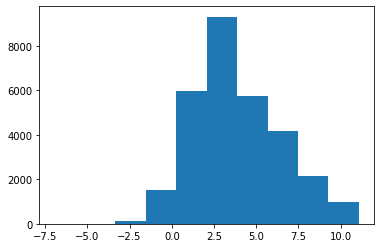

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(labels)

In [15]:
from openchem.data.utils import get_tokens
tokens, _, _ = get_tokens(smiles)
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
tokens = ''.join(tokens) + ' '

In [ ]:
import torch
from openchem.utils.utils import identity
from openchem.modules.embeddings.basic_embedding import Embedding
model_object = Smiles2Label

n_hidden = 128
batch_size = 128
num_epochs = 26
lr = 0.005

param_grid = {
    'n_hidden': [64, 128, 256],
    'batch_size': [64, 128, 256],
    'num_epochs': [10, 20, 30],
    'lr': [0.001, 0.005, 0.01]
}

model_params = {
    'use_cuda': True,
    'random_seed': 42,
    'world_size': 1,
    'task': 'regression',
    'data_layer': SmilesDataset,
    'use_clip_grad': False,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'logdir': './checkpoints/logP/',
    'print_every': 1,
    'save_every': 5,
    'train_data_layer': None,
    'val_data_layer': None,
    'eval_metrics': r2_score,
    'criterion': nn.MSELoss(),
    'optimizer': Adam,
    'optimizer_params': {
        'lr': lr,
    },
    'lr_scheduler': ExponentialLR,
    'lr_scheduler_params': {
        'gamma': 0.98
    },
    'embedding': Embedding,
    'embedding_params': {
        'num_embeddings': len(tokens),
        'embedding_dim': n_hidden,
        'padding_idx': tokens.index(' ')
    },
    'encoder': RNNEncoder,
    'encoder_params': {
        'input_size': n_hidden,
        'layer': "LSTM",
        'encoder_dim': n_hidden,
        'n_layers': 2,
        'dropout': 0.8,
        'is_bidirectional': False
    },
    'mlp': OpenChemMLP,
    'mlp_params': {
        'input_size': n_hidden,
        'n_layers': 2,
        'hidden_size': [n_hidden, 1],
        'activation': [F.relu, identity],
        'dropout': 0.0
    }
}

In [65]:
pickle.dump(model_params, open('./check/cepv2/model_parameters1.pkl', 'wb'))

In [66]:
try:
    os.stat(model_params['logdir'])
except:
    os.mkdir(model_params['logdir'])

In [67]:
log_dir = './check/cepv2/'

In [68]:
tmp_data_dir = './data/tmp/'
try:
    os.stat(tmp_data_dir)
except:
    os.mkdir(tmp_data_dir)

In [69]:
from sklearn.model_selection import KFold, train_test_split

cross_validation_split = KFold(n_splits=6, shuffle=True)

In [70]:
data = list(cross_validation_split.split(smiles, labels))

In [71]:
import warnings

# Filter out UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
best_score = float('-inf')
best_params = None
results = []

for n_hidden in param_grid['n_hidden']:
    for batch_size in param_grid['batch_size']:
        for num_epochs in param_grid['num_epochs']:
            for lr in param_grid['lr']:
                model_params.update({
                    'n_hidden': n_hidden,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'lr': lr
                })
                # Reset your average score for this combination
                avg_rmse=0
                avg_auc=0
                models = []
                results = []
                for split in cross_validation_split.split(data):
                    train, test = split
                    X_train = smiles[train]
                    y_train = labels[train].reshape(-1)
                    X_test = smiles[test]
                    y_test = labels[test].reshape(-1)
                    save_smiles_property_file(tmp_data_dir + str(i) + '_train.smi', 
                                              X_train, y_train.reshape(-1, 1))
                    save_smiles_property_file(tmp_data_dir + str(i) + '_test.smi', 
                                              X_test, y_test.reshape(-1, 1))

                    train_dataset = SmilesDataset(tmp_data_dir + str(i) + '_train.smi',
                                           delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                                 flip=False,)
                    train_dataset.target = train_dataset.target
                    test_dataset = SmilesDataset(tmp_data_dir + str(i) + '_test.smi',
                                       delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                                flip=False)
                    test_dataset.target = test_dataset.target
                    model_params['train_data_layer'] = train_dataset
                    model_params['val_data_layer'] = test_dataset
                    model_params['logdir'] = log_dir + 'fold_' + str(i)  
                    ckpt_dir = model_params['logdir'] + '/checkpoint/'
                    try:
                        os.stat(ckpt_dir)
                    except:
                        os.mkdir(model_params['logdir'])
                        os.mkdir(ckpt_dir)
                    train_loader = create_loader(train_dataset,
                                             batch_size=model_params['batch_size'],
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True,
                                             sampler=None)
                    val_loader = create_loader(test_dataset,
                                           batch_size=model_params['batch_size'],
                                           shuffle=False,
                                           num_workers=1,
                                           pin_memory=True)
                    models.append(model_object(params=model_params).cuda())
                    criterion, optimizer, lr_scheduler = build_training(models[i], model_params)
                    results.append(fit(models[i], lr_scheduler, train_loader, optimizer, criterion,
                        model_params, eval=True, val_loader=val_loader))

                    i = i+1
                    # Your existing code to train and evaluate the model
                    # Update avg_score based on your evaluation metric
                avg_score /= cross_validation_split.n_splits
                results.append((n_hidden, batch_size, num_epochs, lr, avg_score))
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = (n_hidden, batch_size, num_epochs, lr)

# Output the best parameters
print(f"Best Score: {best_score}")
print(f"Best Parameters: n_hidden={best_params[0]}, batch_size={best_params[1]}, num_epochs={best_params[2]}, lr={best_params[3]}")

In [72]:
import os
i = 0
models = []
results = []
for split in data:
    print('Cross validation, fold number ' + str(i) + ' in progress...')
    train, test = split
    X_train = smiles[train]
    y_train = labels[train].reshape(-1)
    X_test = smiles[test]
    y_test = labels[test].reshape(-1)
    save_smiles_property_file(tmp_data_dir + str(i) + '_train.smi', 
                              X_train, y_train.reshape(-1, 1))
    save_smiles_property_file(tmp_data_dir + str(i) + '_test.smi', 
                              X_test, y_test.reshape(-1, 1))

    train_dataset = SmilesDataset(tmp_data_dir + str(i) + '_train.smi',
                           delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                 flip=False,)
    train_dataset.target = train_dataset.target
    test_dataset = SmilesDataset(tmp_data_dir + str(i) + '_test.smi',
                       delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                flip=False)
    test_dataset.target = test_dataset.target
    model_params['train_data_layer'] = train_dataset
    model_params['val_data_layer'] = test_dataset
    model_params['logdir'] = log_dir + 'fold_' + str(i)  
    ckpt_dir = model_params['logdir'] + '/checkpoint/'
    try:
        os.stat(ckpt_dir)
    except:
        os.mkdir(model_params['logdir'])
        os.mkdir(ckpt_dir)
    train_loader = create_loader(train_dataset,
                             batch_size=model_params['batch_size'],
                             shuffle=True,
                             num_workers=4,
                             pin_memory=True,
                             sampler=None)
    val_loader = create_loader(test_dataset,
                           batch_size=model_params['batch_size'],
                           shuffle=False,
                           num_workers=1,
                           pin_memory=True)
    models.append(model_object(params=model_params).cuda())
    criterion, optimizer, lr_scheduler = build_training(models[i], model_params)
    results.append(fit(models[i], lr_scheduler, train_loader, optimizer, criterion,
        model_params, eval=True, val_loader=val_loader))
    
    i = i+1

Cross validation, fold number 0 in progress...




  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/196 [00:00<?, ?it/s]


  1%|          | 1/196 [00:00<00:39,  4.90it/s]


  2%|▏         | 3/196 [00:00<00:32,  5.86it/s]


  3%|▎         | 5/196 [00:00<00:28,  6.80it/s]


  4%|▎         | 7/196 [00:00<00:24,  7.65it/s]


  5%|▍         | 9/196 [00:00<00:22,  8.43it/s]


  6%|▌         | 11/196 [00:01<00:20,  9.08it/s]


  7%|▋         | 13/196 [00:01<00:19,  9.49it/s]


  8%|▊         | 15/196 [00:01<00:18,  9.95it/s]


  9%|▊         | 17/196 [00:01<00:17, 10.44it/s]


 10%|▉         | 19/196 [00:01<00:16, 10.92it/s]


 11%|█         | 21/196 [00:01<00:15, 11.09it/s]


 12%|█▏        | 23/196 [00:02<00:15, 11.02it/s]


 13%|█▎        | 25/196 [00:02<00:15, 11.31it/s]


 14%|█▍        | 27/196 [00:02<00:15, 11.24it/s]


 15%|█▍        | 29/196 [00:02<00:14, 11.23it/s]


 16%|█▌        | 31/196 [00:02<00:14, 11.37it/s]


 17%|█▋        | 33/196 [00:03<00:14, 11.23it/s]


 18%|█▊        | 35/196 [00:03<00:14, 11.32it/s]


 1

Cross validation, fold number 1 in progress...




  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/196 [00:00<?, ?it/s]


  1%|          | 1/196 [00:00<01:23,  2.33it/s]


  1%|          | 2/196 [00:00<01:16,  2.55it/s]


  2%|▏         | 3/196 [00:01<01:09,  2.79it/s]


  2%|▏         | 4/196 [00:01<01:01,  3.11it/s]


  3%|▎         | 5/196 [00:01<00:58,  3.28it/s]


  3%|▎         | 6/196 [00:01<00:54,  3.50it/s]


  4%|▎         | 7/196 [00:02<00:52,  3.59it/s]


  4%|▍         | 8/196 [00:02<00:52,  3.60it/s]


  5%|▍         | 9/196 [00:02<00:53,  3.52it/s]


  5%|▌         | 10/196 [00:02<00:49,  3.79it/s]


  6%|▌         | 11/196 [00:03<00:47,  3.91it/s]


  6%|▌         | 12/196 [00:03<00:47,  3.87it/s]


  7%|▋         | 13/196 [00:03<00:47,  3.88it/s]


  7%|▋         | 14/196 [00:03<00:47,  3.80it/s]


  8%|▊         | 15/196 [00:04<00:46,  3.88it/s]


  8%|▊         | 16/196 [00:04<00:46,  3.84it/s]


  9%|▊         | 17/196 [00:04<00:46,  3.85it/s]


  9%|▉         | 18/196 [00:04<00:45,  3.92it/s]


 10%|▉

Cross validation, fold number 2 in progress...




  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/196 [00:00<?, ?it/s]


  1%|          | 1/196 [00:00<00:43,  4.50it/s]


  2%|▏         | 3/196 [00:00<00:35,  5.50it/s]


  3%|▎         | 5/196 [00:00<00:29,  6.46it/s]


  4%|▎         | 7/196 [00:00<00:25,  7.38it/s]


  5%|▍         | 9/196 [00:00<00:22,  8.16it/s]


  6%|▌         | 11/196 [00:01<00:21,  8.76it/s]


  7%|▋         | 13/196 [00:01<00:19,  9.29it/s]


  8%|▊         | 15/196 [00:01<00:18,  9.74it/s]


  9%|▊         | 17/196 [00:01<00:17, 10.32it/s]


 10%|▉         | 19/196 [00:01<00:16, 10.46it/s]


 11%|█         | 21/196 [00:02<00:16, 10.83it/s]


 12%|█▏        | 23/196 [00:02<00:15, 11.07it/s]


 13%|█▎        | 25/196 [00:02<00:17, 10.01it/s]


 14%|█▍        | 27/196 [00:02<00:16, 10.27it/s]


 15%|█▍        | 29/196 [00:02<00:16, 10.40it/s]


 16%|█▌        | 31/196 [00:02<00:15, 10.63it/s]


 17%|█▋        | 33/196 [00:03<00:15, 10.81it/s]


 18%|█▊        | 35/196 [00:03<00:14, 11.09it/s]


 1

Cross validation, fold number 3 in progress...




  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/196 [00:00<?, ?it/s]


  1%|          | 1/196 [00:00<01:11,  2.71it/s]


  1%|          | 2/196 [00:00<01:05,  2.98it/s]


  2%|▏         | 3/196 [00:00<00:59,  3.25it/s]


  2%|▏         | 4/196 [00:01<00:55,  3.43it/s]


  3%|▎         | 5/196 [00:01<00:53,  3.56it/s]


  3%|▎         | 6/196 [00:01<00:52,  3.64it/s]


  4%|▎         | 7/196 [00:01<00:51,  3.70it/s]


  4%|▍         | 8/196 [00:02<00:51,  3.65it/s]


  5%|▍         | 9/196 [00:02<00:50,  3.72it/s]


  5%|▌         | 10/196 [00:02<00:50,  3.72it/s]


  6%|▌         | 11/196 [00:02<00:48,  3.83it/s]


  6%|▌         | 12/196 [00:03<00:47,  3.86it/s]


  7%|▋         | 13/196 [00:03<00:47,  3.88it/s]


  7%|▋         | 14/196 [00:03<00:48,  3.73it/s]


  8%|▊         | 15/196 [00:03<00:45,  3.95it/s]


  8%|▊         | 16/196 [00:04<00:45,  3.93it/s]


  9%|▊         | 17/196 [00:04<00:47,  3.75it/s]


  9%|▉         | 18/196 [00:04<00:44,  3.97it/s]


 10%|▉

Cross validation, fold number 4 in progress...




  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/196 [00:00<?, ?it/s]


  1%|          | 1/196 [00:00<01:06,  2.92it/s]


  1%|          | 2/196 [00:00<01:00,  3.19it/s]


  2%|▏         | 3/196 [00:00<00:54,  3.52it/s]


  2%|▏         | 4/196 [00:01<00:53,  3.62it/s]


  3%|▎         | 5/196 [00:01<00:50,  3.76it/s]


  3%|▎         | 6/196 [00:01<00:50,  3.74it/s]


  4%|▎         | 7/196 [00:01<00:50,  3.78it/s]


  4%|▍         | 8/196 [00:02<00:48,  3.88it/s]


  5%|▍         | 9/196 [00:02<00:49,  3.80it/s]


  5%|▌         | 10/196 [00:02<00:47,  3.88it/s]


  6%|▌         | 11/196 [00:02<00:47,  3.88it/s]


  6%|▌         | 12/196 [00:03<00:48,  3.82it/s]


  7%|▋         | 13/196 [00:03<00:47,  3.83it/s]


  7%|▋         | 14/196 [00:03<00:47,  3.85it/s]


  8%|▊         | 15/196 [00:03<00:46,  3.87it/s]


  8%|▊         | 16/196 [00:04<00:45,  3.96it/s]


  9%|▊         | 17/196 [00:04<00:45,  3.91it/s]


  9%|▉         | 18/196 [00:04<00:46,  3.83it/s]


 10%|▉

Cross validation, fold number 5 in progress...




  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/196 [00:00<?, ?it/s]


  1%|          | 1/196 [00:00<00:41,  4.73it/s]


  2%|▏         | 3/196 [00:00<00:33,  5.74it/s]


  3%|▎         | 5/196 [00:00<00:28,  6.70it/s]


  4%|▎         | 7/196 [00:00<00:24,  7.62it/s]


  5%|▍         | 9/196 [00:00<00:21,  8.59it/s]


  6%|▌         | 11/196 [00:01<00:20,  9.20it/s]


  7%|▋         | 13/196 [00:01<00:18,  9.92it/s]


  8%|▊         | 15/196 [00:01<00:17, 10.26it/s]


  9%|▊         | 17/196 [00:01<00:16, 10.73it/s]


 10%|▉         | 19/196 [00:01<00:16, 10.55it/s]


 11%|█         | 21/196 [00:01<00:16, 10.87it/s]


 12%|█▏        | 23/196 [00:02<00:15, 11.20it/s]


 13%|█▎        | 25/196 [00:02<00:14, 11.42it/s]


 14%|█▍        | 27/196 [00:02<00:14, 11.27it/s]


 15%|█▍        | 29/196 [00:02<00:15, 11.12it/s]


 16%|█▌        | 31/196 [00:02<00:15, 10.98it/s]


 17%|█▋        | 33/196 [00:03<00:15, 10.78it/s]


 18%|█▊        | 35/196 [00:03<00:14, 11.05it/s]


 1

In [73]:
import numpy as np
rmse = []
auc_score = []
for i in range(5):
    test_dataset = SmilesDataset(tmp_data_dir + str(i) + '_test.smi',
                                 delimiter=',', cols_to_read=[0, 1], tokens=tokens,
                                flip=False)
    test_dataset.target = test_dataset.target
    val_loader = create_loader(test_dataset,
                               batch_size=model_params['batch_size'],
                               shuffle=False,
                               num_workers=1,
                               pin_memory=True)
    metrics = evaluate(models[i], val_loader, criterion)
    rmse.append(np.sqrt(metrics[0]))
    auc_score.append(metrics[1])

In [74]:
print("Cross-validated RMSE: ",  np.mean(rmse))
print("Cross-validated R2 score: ", np.mean(auc_score))

Cross-validated RMSE:  1.3937140754457538
Cross-validated R2 score:  0.6964235565312381


In [75]:
! mv ./check/cepv2/fold_0/checkpoint/epoch_25 ./check/cepv2/fold_0.pkl
! mv ./check/cepv2/fold_1/checkpoint/epoch_25 ./check/cepv2/fold_1.pkl
! mv ./check/cepv2/fold_2/checkpoint/epoch_25 ./check/cepv2/fold_2.pkl
! mv ./check/cepv2/fold_3/checkpoint/epoch_25 ./check/cepv2/fold_3.pkl
! mv ./check/cepv2/fold_4/checkpoint/epoch_25 ./check/cepv2/fold_4.pkl